In [1]:
from torchtext import data, datasets
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

import collections
import random
from res.helper import FixBatchGenerator

# INF554 - Machine and Deep Learning
## Lab 8 - Working with Text, Regularization and Recurrent Neural Networks

In this lab we will be making some *sentiment analysis* with textual data from the IMDB dataset. In its simplest form, the *sentiment analysis* task consists in predicting the polarity of a text as positive or negative.

First of all, let's take a look at the steps of text processing:

1. Tokenization: break sentence into individual words
    - Before: `"PyTorch seems really easy to use!"`
    - After: `["PyTorch", "seems", "really", "easy", "to", "use", "!"]`
2. Building vocabulary: build an index of words associated with unique numbers
    - Before: `["PyTorch", "seems", "really", "easy", "to", "use", "!"]`
    - After: `{"Pytorch: 0, "seems": 1, "really": 2, ...}`
3. Convert to numerals: map words to unique numbers (indices)
    - Before: `{"Pytorch: 0, "seems": 1, "really": 2, ...}`
    - After: `[0, 1, 2, ...]`
4. Embedding look-up: map sentences (indices now) to fixed matrices
    - ```[[0.1, 0.4, 0.3],
       [0.8, 0.1, 0.5],
       ...]```
       
Let's start by creating two fields, **text** which defines how the reviews should be processed, and **label** to store the information about the label of the review (ignore the warnings for now).

In [2]:
# The important field here is fix_length: all examples using this field will be padded to, or None for flexible sequence lengths
# We are setting it at 80 (words) which will represent the maximum size of a sentence in the following
# note that fix_length could also be set at None which means that the size will be flexible (this can be useful for RNNs)
max_len = 80
text = data.Field(sequential=True, fix_length=max_len, batch_first=True, lower=True, dtype=torch.long)
label = data.LabelField(sequential=False, dtype=torch.float)


/usr/local/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: LabelField class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Now let's download the IMDB dataset (~85MB) and create the train, test and validation sets:

In [3]:
#datasets.IMDB.download('./')
ds_train, ds_test = datasets.IMDB.splits(text, label, path='./imdb/aclImdb/')

print('train : ', len(ds_train))
print('test : ', len(ds_test))
print('train.fields :', ds_train.fields)

#make validation set
seed_num = 1337
ds_train, ds_valid = ds_train.split(random_state=random.seed(seed_num))
print('valid : ', len(ds_valid))

/usr/local/lib/python3.8/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


train :  25000
test :  25000
train.fields : {'text': <torchtext.data.field.Field object at 0x106be7f70>, 'label': <torchtext.data.field.LabelField object at 0x106be7f40>}
valid :  7500


Now we build the *vocabulary* (step 2 above), mapping every word into a numerical id. We consider only text in the training set for this step.

In [4]:
# Build vocabulary
# num_words = 25000 #usually we would use a bigger size but we are reducing to make results worse and get the results faster
num_words = 1000
text.build_vocab(ds_train, max_size=num_words)
label.build_vocab(ds_train)

# Print vocab size
print('Vocabulary size: {}'.format(len(text.vocab)))
print('Label size: {}'.format(len(label.vocab)))

# Print most common vocabulary text
most_common_samples = 10
print(text.vocab.freqs.most_common(most_common_samples))

# Print most common labels
print(label.vocab.freqs.most_common())

Vocabulary size: 1002
Label size: 2
[('the', 225411), ('a', 111661), ('and', 110736), ('of', 101281), ('to', 93618), ('is', 73247), ('in', 63011), ('i', 49141), ('this', 49010), ('that', 46426)]
[('neg', 8835), ('pos', 8665)]


Let's inspect the content of a review:

In [5]:
def show_text(sample):
    print(' '.join(word for word in sample))
    
show_text(ds_train[0].text)
print('label: ', ds_train[0].label)

just about everything in this movie is wrong, wrong, wrong. take mike myers, for example. he's reached the point where you realize that his shtick hasn't changed since his snl days, over ten years ago. he's doing the same cutesy stream-of-consciousness jokes and the same voices. his cat is painfully unfunny. he tries way to hard. he's some weird type a comedian, not the cool cat he's supposed to be. the rest of the movie is just as bad. the sets are unbelievably ugly --- and clearly a waste of millions of dollars. (cardboard cut-outs for the background buildings would have made more sense than constructing an entire neighborhood and main street.) alec balwin tries to do a funny great santini impression, but he ends up looking and sounding incoherent. there's even an innapropriate cheesecake moment with faux celebrity paris hilton --- that sticks in the mind simply because this is supposed to be a dr. seuss story. avoid this movie at all costs, folks. it's not even an interesting train 

Now, we create and load the batches for training:

In [6]:
batch_size = 64
train_loader, valid_loader, test_loader = data.BucketIterator.splits(
    (ds_train, ds_valid, ds_test), batch_size=batch_size, sort_key=lambda x: len(x.text), repeat=False
)

train_loader, valid_loader, test_loader = FixBatchGenerator(train_loader, 'text', 'label'), FixBatchGenerator(valid_loader, 'text', 'label'), FixBatchGenerator(test_loader, 'text', 'label')

/usr/local/lib/python3.8/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


We introduce now a fully connected NN for text classification

In [62]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        # Linear function
        self.fc1 = nn.Linear(80*embedding_dim, hidden_dim) 
        
        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Embedding
        embedded = self.embedding(x)
        #embedded size is [batch size, embedding_dim, embedding_dim]
        embedded = embedded.view(-1, 80*embedding_dim)

        # Linear function
        out = self.fc1(embedded)

        # Non-linearity
        out = torch.relu(out)

        # Take note here use a final sigmoid function so your loss should not go through sigmoid again as we are using BCE loss.
        out = self.fc2(out)
        out = torch.sigmoid(out)
    
        return out

The following block sets up the network with <a href="https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html">Binary Cross Entropy</a> loss and <a href="https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html">RMSprop</a> optimizer.

RMSprop is an optimization technique that uses a moving average of squared gradients to normalize the gradient. This normalization balances the step size (momentum), decreasing the step for large gradients to avoid exploding and increasing the step for small gradients to avoid vanishing. This means that the learning rate changes over time (*adaptive learning rate*).

In [63]:
input_dim = num_words + 2 #add 2 for start and end sentence symbols
embedding_dim = 100
hidden_dim = 32
output_dim = 1

# Instantiate model class and assign to object
model = FeedforwardNeuralNetModel(input_dim, embedding_dim, hidden_dim, output_dim)

# Push model to CUDA device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function
criterion = nn.BCELoss()

# Optimizer
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)

In [64]:
# Number of groups of parameters
print('Number of groups of parameters {}'.format(len(list(model.parameters()))))
print('-'*50)
# Print parameters
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())
print('-'*50)

Number of groups of parameters 5
--------------------------------------------------
torch.Size([1002, 200])
torch.Size([32, 16000])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])
--------------------------------------------------


The following function carries out the training

In [65]:
def train_model(model, optizmizer, loss_criterion):
    iter = 0
    num_epochs = 10
    history_train_acc, history_val_acc, history_train_loss, history_val_loss = [], [], [], []
    best_accuracy = 0
    for epoch in range(num_epochs):
        for i, (samples, labels) in enumerate(train_loader):
            # Training mode
            model.train()

            # Load samples
            samples = samples.view(-1, max_len).to(device)
            labels = labels.view(-1, 1).to(device)

            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()

            # Forward pass to get output/logits
            outputs = model(samples)

            # Calculate Loss: softmax --> cross entropy loss
            loss = loss_criterion(outputs, labels)

            # Getting gradients w.r.t. parameters
            loss.backward()

            # Updating parameters
            optimizer.step()

            iter += 1

            if iter % 100 == 0:
                # Get training statistics
                train_loss = loss.data.item()

                # Testing mode
                model.eval()
                # Calculate Accuracy         
                correct = 0
                total = 0
                # Iterate through test dataset
                for samples, labels in valid_loader:
                    # Load samples
                    samples = samples.view(-1, max_len).to(device)
                    labels = labels.view(-1).to(device)

                    # Forward pass only to get logits/output
                    outputs = model(samples)

                    # Val loss
                    val_loss = criterion(outputs.view(-1, 1), labels.view(-1, 1))

                    predicted = outputs.ge(0.5).view(-1)

                    # Total number of labels
                    total += labels.size(0)

                    # Total correct predictions
                    correct += (predicted.type(torch.FloatTensor).cpu() == labels.type(torch.FloatTensor)).sum().item()
                    # correct = (predicted == labels.byte()).int().sum().item()

                accuracy = 100. * correct / total

                # Print Loss
                print('Iter: {} | Train Loss: {} | Val Loss: {} | Val Accuracy: {}'.format(iter, train_loss, val_loss.item(), round(accuracy, 2)))

                # Append to history
                history_val_loss.append(val_loss.data.item())
                history_val_acc.append(round(accuracy, 2))
                history_train_loss.append(train_loss)

                # Save model when accuracy beats best accuracy
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    # We can load this best model on the validation set later
                    torch.save(model.state_dict(), 'best_model.pth')
    return (history_train_acc, history_val_acc, history_train_loss, history_val_loss)



This function plots the losses for the testing and validation sets:

In [66]:
def plot_losses(history_train_loss, history_val_loss):
    # Set plotting style
    #plt.style.use(('dark_background', 'bmh'))
    plt.style.use('bmh')
    plt.rc('axes', facecolor='none')
    plt.rc('figure', figsize=(16, 4))

    # Plotting loss graph
    plt.plot(history_train_loss, label='Train')
    plt.plot(history_val_loss, label='Validation')
    plt.title('Loss Graph')
    plt.legend()
    plt.show()

Let's observe the behaviour of the model:

In [67]:
(train_acc, val_acc, train_loss, val_loss) = train_model(model, optimizer, criterion)

Iter: 100 | Train Loss: 0.7034580111503601 | Val Loss: 0.6933199763298035 | Val Accuracy: 52.09
Iter: 200 | Train Loss: 0.6938658952713013 | Val Loss: 0.6856935024261475 | Val Accuracy: 54.41
Iter: 300 | Train Loss: 0.6424086093902588 | Val Loss: 0.6913643479347229 | Val Accuracy: 55.03
Iter: 400 | Train Loss: 0.6707993149757385 | Val Loss: 0.6445432305335999 | Val Accuracy: 56.96
Iter: 500 | Train Loss: 0.6557962894439697 | Val Loss: 0.6282934546470642 | Val Accuracy: 58.29
Iter: 600 | Train Loss: 0.5366172194480896 | Val Loss: 0.4204540252685547 | Val Accuracy: 60.88
Iter: 700 | Train Loss: 0.65838223695755 | Val Loss: 0.5491631031036377 | Val Accuracy: 60.68
Iter: 800 | Train Loss: 0.42394182085990906 | Val Loss: 0.5405511260032654 | Val Accuracy: 62.13
Iter: 900 | Train Loss: 0.4437568187713623 | Val Loss: 0.5878576636314392 | Val Accuracy: 63.01
Iter: 1000 | Train Loss: 0.396431565284729 | Val Loss: 0.42701220512390137 | Val Accuracy: 63.69
Iter: 1100 | Train Loss: 0.3013844788074

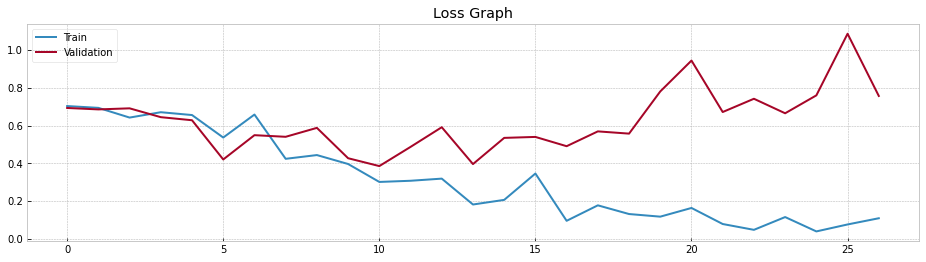

In [68]:
plot_losses(train_loss, val_loss)

> **Ques 1**: What can you deduce from this graph? Is the network working as expected?

Regularization techniques are required to reduce overfitting (i.e. the predictor fits too closely to the training data and does not generalize well to new data). Overfitting tends to occur when we have little data and a complex hypothesis class.

A first idea for regularization is to introduce a *penalty term*, which makes it harder for the optimizer to return an overly flexible predictor.

We will start by adding a regularization term to our (point-wise) loss:

$$ loss_R = loss + \frac{\lambda}{2}\left\Vert W\right\Vert _{2}^{2}$$

The gradient for the regularized loss is therefore:

$$\nabla_W loss_R = \nabla_W loss + \lambda W$$

With pytorch, adding a regularization term is done on the optimization function by adding the parameter *weight_decay* (corresponding to the above $\lambda$) to the call to the optimizer.

> **Task 1**: set the optimizer *weight_decay* to 0.005 and re-train the model, studying its behaviour

You can use the following function to take a look at the parameters of the model before and after regularization:

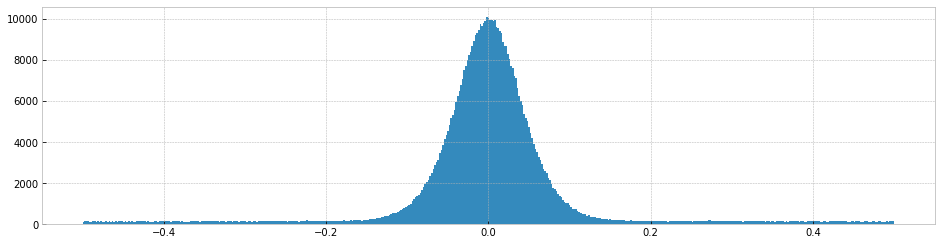

In [69]:
def look_parameters(mdl):
    weights = torch.Tensor().to(device)
    for param_group in list(mdl.parameters()):
        weights = torch.cat((param_group.view(-1), weights))
    ws = weights.detach().numpy()
    plt.hist(ws.reshape(-1), range=(-.5, .5), bins=501)

look_parameters(model)

In [70]:
#enter here the code for Task 1

optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3, weight_decay=0.005)
(train_acc, val_acc, train_loss, val_loss) = train_model(model, optimizer, criterion)

/usr/local/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Iter: 100 | Train Loss: 0.10787021368741989 | Val Loss: 0.8192270398139954 | Val Accuracy: 64.2
Iter: 200 | Train Loss: 0.17665405571460724 | Val Loss: 0.7206869125366211 | Val Accuracy: 64.15
Iter: 300 | Train Loss: 0.1350599229335785 | Val Loss: 0.8826000094413757 | Val Accuracy: 64.53
Iter: 400 | Train Loss: 0.13046887516975403 | Val Loss: 0.7091047167778015 | Val Accuracy: 64.77
Iter: 500 | Train Loss: 0.23305119574069977 | Val Loss: 0.8418693542480469 | Val Accuracy: 64.71
Iter: 600 | Train Loss: 0.1307666003704071 | Val Loss: 0.7940548062324524 | Val Accuracy: 64.79
Iter: 700 | Train Loss: 0.3997218608856201 | Val Loss: 0.677175760269165 | Val Accuracy: 61.69
Iter: 800 | Train Loss: 0.3167663812637329 | Val Loss: 0.61629718542099 | Val Accuracy: 64.63
Iter: 900 | Train Loss: 0.1770399808883667 | Val Loss: 0.4461371898651123 | Val Accuracy: 64.28
Iter: 1000 | Train Loss: 0.24287395179271698 | Val Loss: 0.3947584927082062 | Val Accuracy: 64.19
Iter: 1100 | Train Loss: 0.27428701519

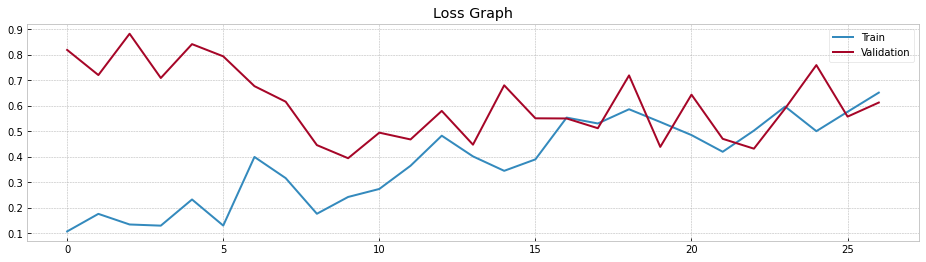

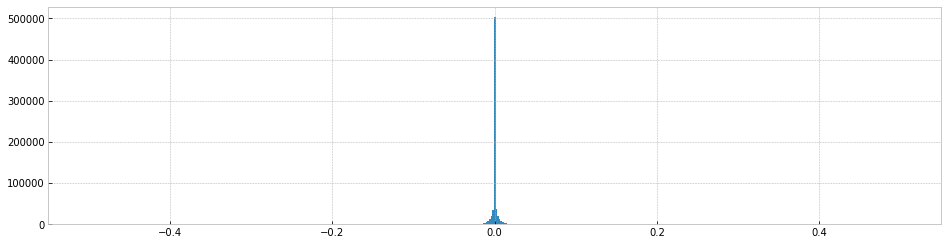

In [71]:
plot_losses(train_loss, val_loss)
look_parameters(model)

## Dropout

Another solution for regularization in neural network consists in applying **Dropout**: at each step of training, a new subnetwork is selected. As a result an adaptation appears in the final network only if it exists in a sufficient part of the training data.

<img src="figures/dropout.png" alt="dropout" width="400"/><font size="1">Image from (Srivastava et al. ,2014) Dropout: A Simple Way to Prevent Neural Networks from
Overfitting, JMLR</font>

We need to introduce a probability $p$ of deactivating a neuron in the hidden layers. So, if we have $n$ neurons in layer $l$, we expect to have $n * (1-p)$ active neurons.

Therefore the output of a generic layer becomes:

$$ z^l = \alpha(W_l^\top \delta z^{l-1} + b_l) $$

with $\delta \sim Bernoulli(p)$ and $\alpha(x)$ an activation function.

> **Task 2** : add <a href="https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html">dropout</a> to the neural network above, between the two fully connected layers, with p=0.8; re-train the new network and observe the result (note: use the optimizer without weight_decay).

In [ ]:
class FeedforwardNeuralNetModelWithDropout(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModelWithDropout, self).__init__()
        # Embedding layer
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        # Linear function
        self.fc1 = nn.Linear(80*embedding_dim, hidden_dim) 
        
        #insert here your code
        # SOLUTION Task 2: Dropout
        self.dropout = nn.Dropout(0.8)
        
        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Embedding
        embedded = self.embedding(x)
        embedded = embedded.view(-1, 80*embedding_dim)
        # Linear function
        out = self.fc1(embedded)

        # Non-linearity
        out = torch.relu(out)
        
        #insert here your code
        # SOLUTION Task 2: Dropout
        out = self.dropout(out)

        # Take note here use a final sigmoid function so your loss should not go through sigmoid again as we are using BCE loss.
        out = self.fc2(out)
        out = torch.sigmoid(out)
    
        return out
    


In [ ]:
#insert here your code

# Instantiate model class and assign to object
model_dropout= FeedforwardNeuralNetModelWithDropout(input_dim, embedding_dim, hidden_dim, output_dim)

# Optimizer
optimizer = torch.optim.RMSprop(model_dropout.parameters(), lr=1e-3)

In [ ]:
(train_acc, val_acc, train_loss, val_loss) = train_model(model_dropout, optimizer, criterion)
plot_losses(train_loss, val_loss)

## Using LSTM to classify textual data

A fully connected neural network is not an ideal way of processing textual data. Recurrent Neural Networks are more useful for this task since they are more adequate to work on sequential data such as text.

A particular type of RNN is the Long Short-Term Memory, or <a href="https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html">LSTM</a>.

> **Task 3** : complete the following code to implement a single layer, unidirectional LSTM with a fully connected layer taking the final hidden states of the LSTM as input. Note that you have to set the parameter *batch_first*=True for the LSTM layer as our dataset comes in this format.


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_class):
        """
        vocab_size: (int) size of the vocabulary - required by embeddings
        embed_dim: (int) size of embeddings
        hidden_dim: (int) number of hidden units
        num_class: (int) number of classes
        """
        super().__init__()
        self.hidden_dim=hidden_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        #enter here your code
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=1, bidirectional=False, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_class)
        #SOLUTION task 5
        #self.dropout = nn.Dropout(0.8)
        

    def forward(self, text):
        r"""
        Arguments:
            text: 1-D tensor representing a bag of text tensors
        """
        #ENTER HERE YOUR CODE
        text=self.embedding(text)
        output, (hidden, cell) = self.lstm(text)
        #for the sizes:
        #output:[batch_size, sent_len, hidden_dim*num directions]
        #hidden: [num_layers * num_directions, batch_size, hidden_dim]
        x = hidden.view(-1, self.hidden_dim)
        #SOLUTION task 5
        #x=self.dropout(x)
        x=self.fc(x)
        out = torch.sigmoid(x)
        return out

> **Task 4**: run the LSTM model on the IMDB dataset and verify whether it is overfitting or not. 

In [ ]:
#insert your code here
#Solution Task 4
lstm = LSTMModel(input_dim, embedding_dim, hidden_dim, output_dim)

# Optimizer
optimizer = torch.optim.RMSprop(lstm.parameters(), lr=1e-3) #not necessary if the order is respected

(train_acc, val_acc, train_loss, val_loss) = train_model(lstm, optimizer, criterion)
plot_losses(train_loss, val_loss)

> **Task 5**: implement a dropout layer between the LSTM and the fully connected layer 